# Training Integrator Comparison for a Dense Neural network based integrator

In [ ]:
import sys
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt
from Code.dynamical_system import *
from Code.time_integrator import *
from Code.neuralnet import *

np.random.seed(2512517)

## Neural network integrator


Set system parameters, construct dynamical system and integrator.

The model system we are using here is the double well oscillator.

The timestep size of the Neural network integrator is set to $\Delta t=20\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 4, 2)]       0           []                               
                                                                                                  
 flatten_3 (Flatten)            (None, 8)            0           ['input_4[0][0]']                
                                                                                                  
 dense_12 (Dense)               (None, 64)           576         ['flatten_3[0][0]']              
                                                                                                  
 dense_13 (Dense)               (None, 64)           4160        ['dense_12[0][0]']               
                                                                                            

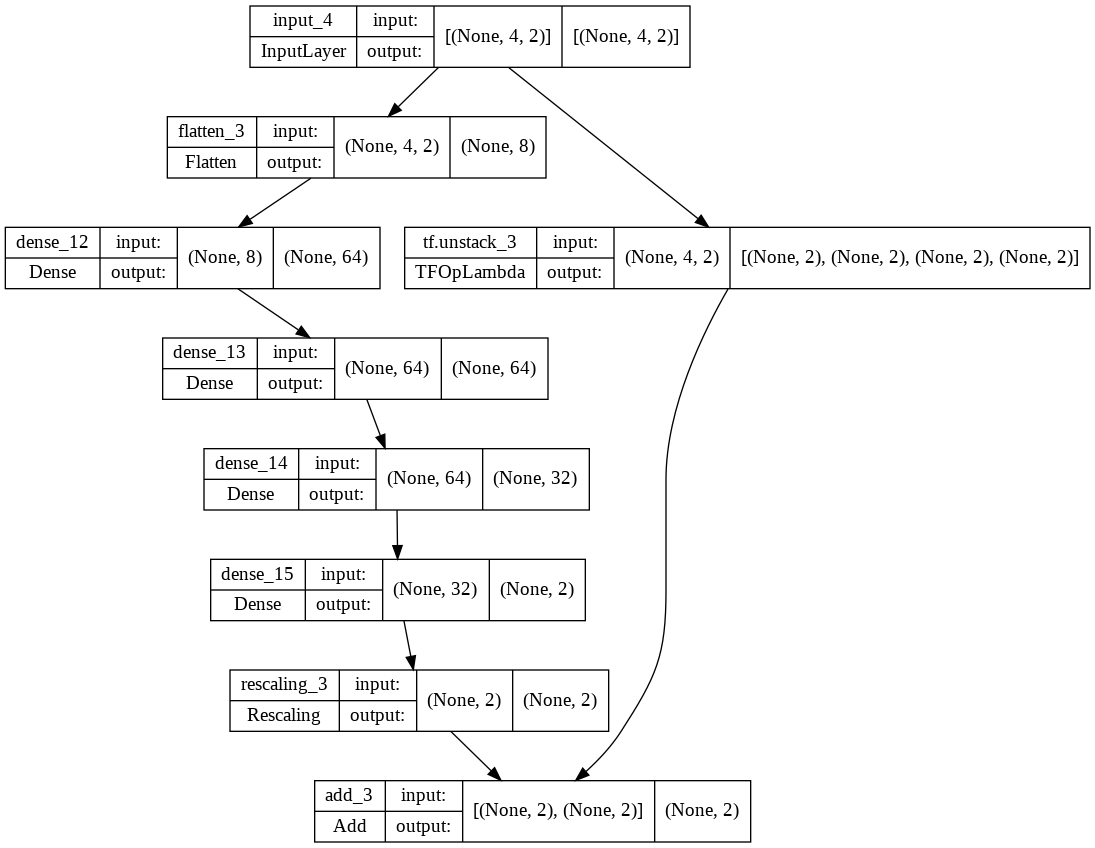

In [ ]:
# mass of particle
mass = 1.2
# timestep for Verlet integrator
dt_verlet = 0.005
# timestep for neural network integrator
dt = 20*dt_verlet
# number of steps for neural network integrator
nsteps = 4

doublewell = DoubleWell(mass)

verlet_DW = VerletIntegrator(doublewell,dt_verlet)
euler_DW = ForwardEulerIntegrator(doublewell,dt_verlet)
rk4_DW = RK4Integrator(doublewell,dt_verlet)


nn_integrator_1 = NN5LR3Integrator(doublewell,nsteps,dt)
nn_integrator_2 = NN5LR3Integrator(doublewell,nsteps,dt)
nn_integrator_3 = NN5LR3Integrator(doublewell,nsteps,dt)

# visualise the neural network model
nn_integrator_1.model.summary()
keras.utils.plot_model(nn_integrator_1.model, show_shapes=True)

In [ ]:
BATCH_SIZE=64

data_generator_1 = DataGenerator(nn_integrator_1,verlet_DW)
train_batches_1 = data_generator_1.dataset.batch(BATCH_SIZE)

data_generator_2 = DataGenerator(nn_integrator_2,euler_DW)
train_batches_2 = data_generator_2.dataset.batch(BATCH_SIZE)

data_generator_3 = DataGenerator(nn_integrator_3,rk4_DW)
train_batches_3 = data_generator_3.dataset.batch(BATCH_SIZE)



## Train neural network based integrator



In [ ]:
EPOCHS=300
STEPS_PER_EPOCH=100
log_dir = './tb_logs/'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result_1 = nn_integrator_1.model.fit(train_batches_1,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)
result_2 = nn_integrator_2.model.fit(train_batches_2,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)
result_3 = nn_integrator_3.model.fit(train_batches_3,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                callbacks=tensorboard_cb)


Epoch 1/300
100/100 [==============================] - 9s 89ms/step - loss: 0.0402
Epoch 2/300
100/100 [==============================] - 9s 88ms/step - loss: 0.0265
Epoch 3/300
100/100 [==============================] - 9s 89ms/step - loss: 0.0172
Epoch 4/300
100/100 [==============================] - 9s 89ms/step - loss: 0.0097
Epoch 5/300
100/100 [==============================] - 9s 89ms/step - loss: 0.0066
Epoch 6/300
100/100 [==============================] - 9s 89ms/step - loss: 0.0053
Epoch 7/300
100/100 [==============================] - 9s 89ms/step - loss: 0.0039
Epoch 8/300
100/100 [==============================] - 9s 90ms/step - loss: 0.0033
Epoch 9/300
100/100 [==============================] - 9s 93ms/step - loss: 0.0023
Epoch 10/300
100/100 [==============================] - 9s 90ms/step - loss: 0.0017
Epoch 11/300
100/100 [==============================] - 9s 90ms/step - loss: 0.0014
Epoch 12/300
100/100 [==============================] - 9s 95ms/step - loss: 0.0011
E

## Visualise Loss function

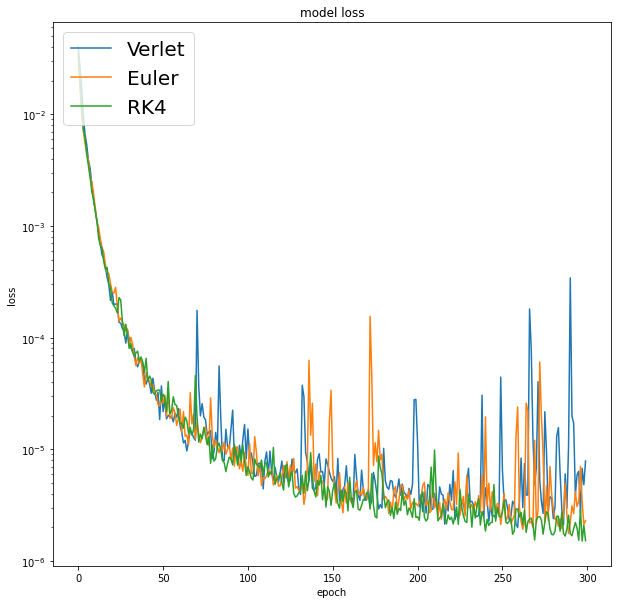

In [ ]:
#print(result.history.keys())

plt.rcParams['figure.figsize'] = [10, 10]

# summarize history for loss
plt.plot(result_1.history['loss'])
plt.plot(result_2.history['loss'])
plt.plot(result_3.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.legend(['Verlet','Euler','RK4'], loc='upper left')
plt.yscale("log")
plt.show()

## Plot trajectories to $t=128$ generated by Verlet integrator and Verlet / Euler / RK4 trained neural network based integrator

In [ ]:
# Final time
T_final = 128

# Initial conditions
x = np.zeros(1)
v = np.zeros(1)
x[0] = 2.4
v[0] = 0.5
verlet_DW.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet_DW = []
x_verlet_DW = []
v_verlet_DW = []
E_verlet_DW = []



while t<T_final:
    t_verlet_DW.append(t)
    E_verlet_DW.append(verlet_DW.energy())
    x_verlet_DW.append(verlet_DW.x[0])
    v_verlet_DW.append(verlet_DW.v[0])
    verlet_DW.integrate(1)
    t += dt_verlet
        

# ==== Neural network integrator ====

# Initialise with Verlet integrator
x_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
v_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
x_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
v_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
x_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))
v_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))



verlet_DW.set_state(x,v)
for k in range(nn_integrator_1.nsteps):    
    x_initial_1[k,:] = verlet_DW.x[:]
    v_initial_1[k,:] = verlet_DW.v[:]
    verlet_DW.integrate(int(dt/dt_verlet))
verlet_DW.set_state(x,v)
for k in range(nn_integrator_2.nsteps):    
    x_initial_2[k,:] = verlet_DW.x[:]
    v_initial_2[k,:] = verlet_DW.v[:]
    verlet_DW.integrate(int(dt/dt_verlet))
verlet_DW.set_state(x,v)
for k in range(nn_integrator_3.nsteps):    
    x_initial_3[k,:] = verlet_DW.x[:]
    v_initial_3[k,:] = verlet_DW.v[:]
    verlet_DW.integrate(int(dt/dt_verlet))


nn_integrator_1.set_state(x_initial_1,v_initial_1)
t_1 = (nn_integrator_1.nsteps-1)*nn_integrator_1.dt
nn_integrator_2.set_state(x_initial_2,v_initial_2)
t_2 = (nn_integrator_2.nsteps-1)*nn_integrator_2.dt
nn_integrator_3.set_state(x_initial_3,v_initial_3)
t_3 = (nn_integrator_3.nsteps-1)*nn_integrator_3.dt



# Timestepping loop
t_nn_1 = []
x_nn_1 = []
v_nn_1 = []
E_nn_1 = []
t_nn_2 = []
x_nn_2 = []
v_nn_2 = []
E_nn_2 = []
t_nn_3 = []
x_nn_3 = []
v_nn_3 = []
E_nn_3 = []


while t_1<T_final:
    t_nn_1.append(t_1)
    x_nn_1.append(nn_integrator_1.x[0])
    v_nn_1.append(nn_integrator_1.v[0])
    E_nn_1.append(nn_integrator_1.energy())
    nn_integrator_1.integrate(1)
    t_1 += dt
while t_2<T_final:
    t_nn_2.append(t_2)
    x_nn_2.append(nn_integrator_2.x[0])
    v_nn_2.append(nn_integrator_2.v[0])
    E_nn_2.append(nn_integrator_2.energy())
    nn_integrator_2.integrate(1)
    t_2 += dt
while t_3<T_final:
    t_nn_3.append(t_3)
    x_nn_3.append(nn_integrator_3.x[0])
    v_nn_3.append(nn_integrator_3.v[0])
    E_nn_3.append(nn_integrator_3.energy())
    nn_integrator_3.integrate(1)
    t_3 += dt
 



x_nn_1 = np.array(x_nn_1)
x_nn_2 = np.array(x_nn_2)
x_nn_3 = np.array(x_nn_3)
x_verlet_DW = np.array(x_verlet_DW)
v_nn_1 = np.array(v_nn_1)
v_nn_2 = np.array(v_nn_2)
v_nn_3 = np.array(v_nn_3)
v_verlet_DW = np.array(v_verlet_DW)




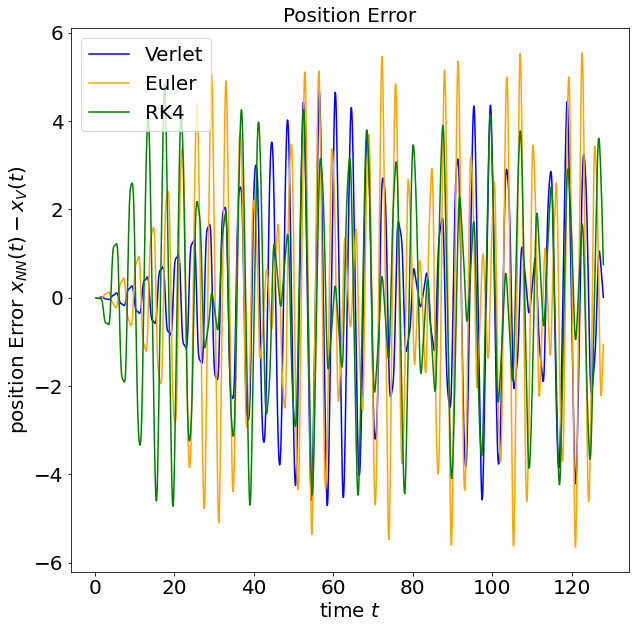

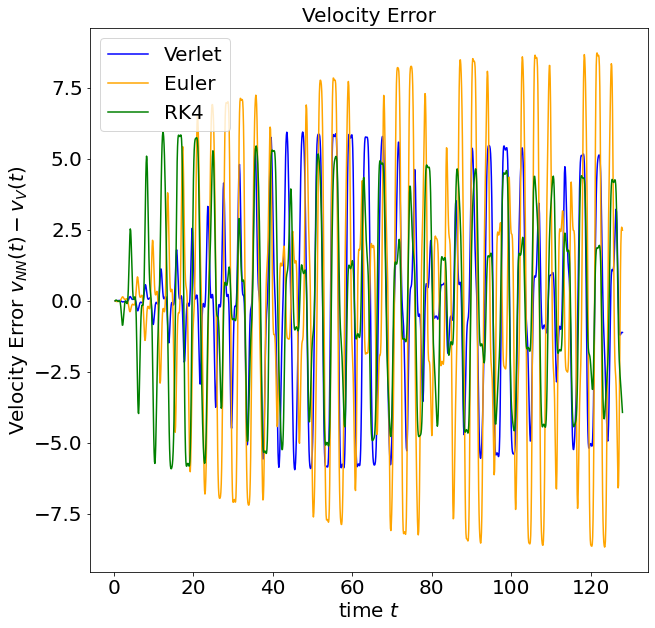

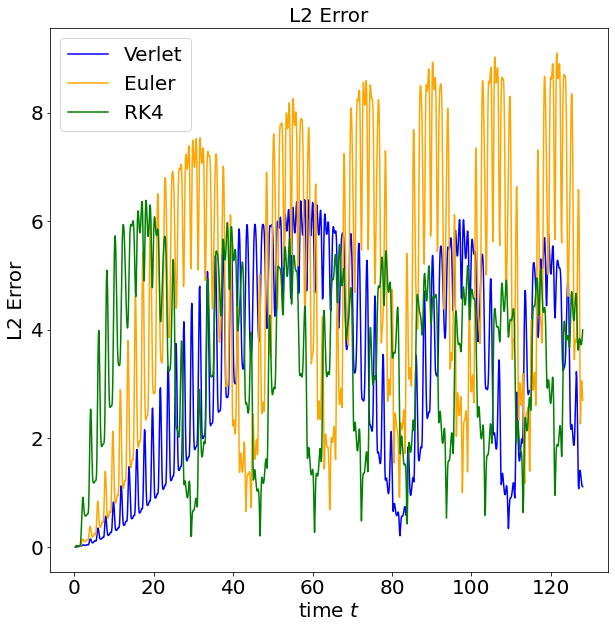

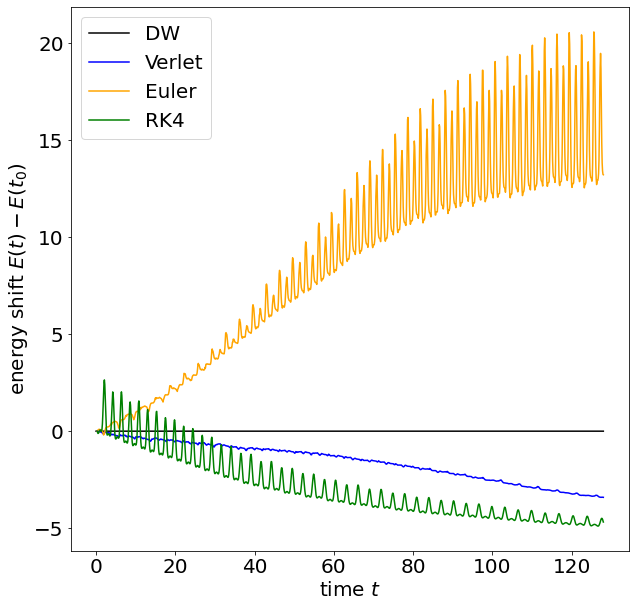

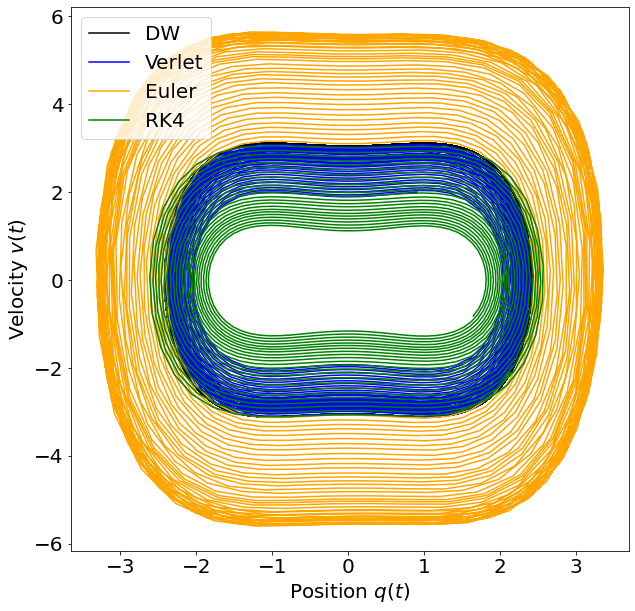

In [ ]:
# Plot position error as a function of time

plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(t_nn_1,x_nn_1-x_verlet_DW[int((nsteps-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='Verlet',color='blue')
plt.plot(t_nn_2,x_nn_2-x_verlet_DW[int((nsteps-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='Euler',color='orange')
plt.plot(t_nn_3,x_nn_3-x_verlet_DW[int((nsteps-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='RK4',color='green')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position Error $x_{NN}(t)-x_V(t)$')
ax.set_title('Position Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot velocity error as a function of time

plt.plot(t_nn_1,v_nn_1-v_verlet_DW[int((nsteps-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='Verlet',color='blue')
plt.plot(t_nn_2,v_nn_2-v_verlet_DW[int((nsteps-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='Euler',color='orange')
plt.plot(t_nn_3,v_nn_3-v_verlet_DW[int((nsteps-1)*dt/dt_verlet)::int(dt/dt_verlet)],label='RK4',color='green')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('Velocity Error $v_{NN}(t)-v_V(t)$')
ax.set_title('Velocity Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot L2 error as a function of time

plt.plot(t_nn_1,((v_nn_1-v_verlet_DW[int((nsteps-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2+(x_nn_1-x_verlet_DW[int((nsteps-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2)**0.5,label='Verlet',color='blue')
plt.plot(t_nn_2,((v_nn_2-v_verlet_DW[int((nsteps-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2+(x_nn_2-x_verlet_DW[int((nsteps-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2)**0.5,label='Euler',color='orange')
plt.plot(t_nn_3,((v_nn_3-v_verlet_DW[int((nsteps-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2+(x_nn_3-x_verlet_DW[int((nsteps-1)*dt/dt_verlet)::int(dt/dt_verlet)])**2)**0.5,label='RK4',color='green')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('L2 Error')
ax.set_title('L2 Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()


plt.clf()
# Plot energy as a function of time
# (subtract energy at time t=0 to show energy drift)

plt.plot(t_verlet_DW,E_verlet_DW-E_verlet_DW[0],label='DW',color='black')
plt.plot(t_nn_1,E_nn_1-E_nn_1[0],label='Verlet',color='blue')
plt.plot(t_nn_2,E_nn_2-E_nn_2[0],label='Euler',color='orange')
plt.plot(t_nn_3,E_nn_3-E_nn_3[0],label='RK4',color='green')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('energy shift $E(t)-E(t_0)$')
#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()

#subplots of position versus velocity for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_DW,v_verlet_DW,label='DW',color='black')
plt.plot(x_nn_1,v_nn_1,label='Verlet',color='blue')
plt.plot(x_nn_2,v_nn_2,label='Euler',color='orange')
plt.plot(x_nn_3,v_nn_3,label='RK4',color='green')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('Velocity $v(t)$')
ax.set_xlabel('Position $q(t)$')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()